In [69]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [70]:
# VARIABLES
CSV_FILE = 'dataset/packet_features_data.csv'

In [71]:
# Load CSV file
df = pd.read_csv(CSV_FILE)

In [72]:
from sklearn.preprocessing import MinMaxScaler
encoders = {}
encoder = OneHotEncoder(sparse_output=False)
# Encode direction
encoded = encoder.fit_transform(df[['direction']])
encoders['direction'] = encoder
dir_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['direction']))
# Encode packetId
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['packetId']])
encoders['packetId'] = encoder
packet_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['packetId']))
# Encode clientProtocolVersion
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['clientProtocolVersion']])
encoders['clientProtocolVersion'] = encoder
client_protocol_version_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['clientProtocolVersion']))

# Concatenate all encoded DataFrames
encoded_df = pd.concat([dir_df, packet_df, client_protocol_version_df], axis='columns', ignore_index=True)
packet_df = pd.DataFrame(df['packetId'])

scalers = {}
for packet_id in df['packetId'].unique():
    scaler = MinMaxScaler()
    rows = (df['packetId'] == packet_id)
    packet_df.loc[rows, 'packet_length_norm'] = scaler.fit_transform(df.loc[rows, ['length']])
    scalers[packet_id] = scaler

scaler = MinMaxScaler()
encoded_df = pd.concat([encoded_df, packet_df['packet_length_norm']], axis='columns', ignore_index=False)
encoded_df['iat_norm'] =  scaler.fit_transform(df[['iat']])
scalers['iat'] = scaler
scalers['packet_ids'] = df['packetId'].unique()




In [73]:
y = df['label'] # e.g. "meteor", "vanilla", etc.

In [74]:
# Split + Normalize
X_train, X_test, y_train, y_test = train_test_split(encoded_df.values, y.values, test_size=0.2, random_state=42, stratify=y)

In [75]:
# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train) # e.g. 'vanilla' → 0, 'meteor' → 1, so on
y_test_int  = le.transform(y_test)

encoders['label'] = le

In [76]:
# Labels one-hot encode if more than 2 classes
num_classes = len(le.classes_)
y_train_enc = to_categorical(y_train_int, num_classes=num_classes)
y_test_enc  = to_categorical(y_test_int,  num_classes=num_classes)

In [77]:
from keras import Input

# Build the model
model = Sequential([
    Input((X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
# Train the model
history = model.fit(X_train, y_train_enc, validation_split=0.1, epochs=20, batch_size=128, verbose=0)

In [79]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_enc)
print(f"Test Accuracy: {accuracy:.4f}")

10739/10739 ━━━━━━━━━━━━━━━━━━━━ 4s 350us/step - accuracy: 0.6668 - loss: 0.6001
Test Accuracy: 0.6656


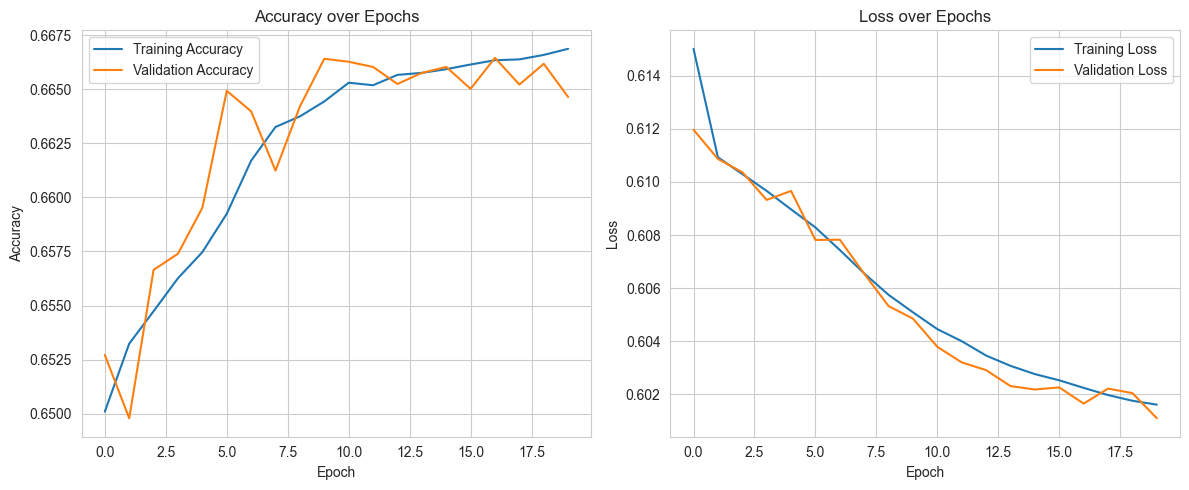

In [80]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# How is the Plot to be interpreted? (English)
The training history plot shows how the model's accuracy and loss change over each epoch for both training and validation data.


- **Accuracy**: Higher values (close to 1.0) mean the model predicts correctly more often. Good accuracy is typically above 0.8, but this depends on the problem.
- **Loss**: Lower values indicate better model performance. A good loss is close to 0, while a high loss means the model is making many mistakes.
If validation accuracy is much lower than training accuracy, or if validation loss increases while training loss decreases, the model may be overfitting.

# Wie ist der Plot zu interpretieren? (Deutsch)
Das Trainingsverlauf-Plot zeigt, wie sich die Genauigkeit (Accuracy) und der Fehlerwert (Loss) des Modells über die Epochen für Trainings- und Validierungsdaten verändern.
- **Genauigkeit**: Hohe Werte (nahe 1.0) bedeuten, dass das Modell oft richtig vorhersagt. Eine gute Genauigkeit liegt meist über 0.8, je nach Problemstellung.
- **Fehlerwert**: Niedrige Werte zeigen eine gute Modellleistung. Ein guter Loss ist nahe 0, ein hoher Loss bedeutet viele Fehler.
Ist die Validierungsgenauigkeit deutlich niedriger als die Trainingsgenauigkeit oder steigt der Validierungs-Loss, während der Trainings-Loss sinkt, könnte das Modell überfitten.

In [81]:
# Confusion Matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_int, y_pred_labels)

labels = le.classes_

10739/10739 ━━━━━━━━━━━━━━━━━━━━ 2s 205us/step


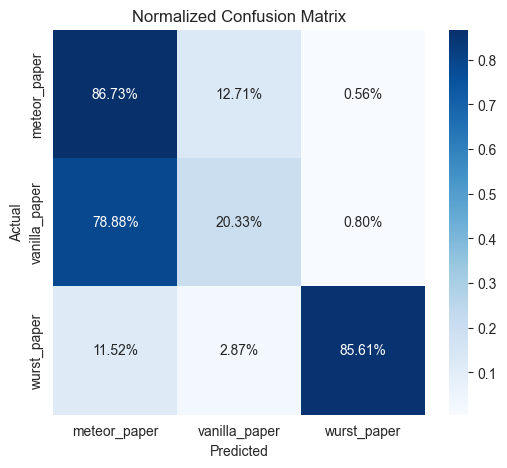

In [82]:
# Heatmap with counts and percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", xticklabels=labels,
            yticklabels=labels, cmap="Blues")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# How is the Confusion Matrix to be interpreted? (English)
The confusion matrix shows how well the model predicts each class compared to the actual labels. Each row represents the true class, while each column represents the predicted class.
- **Diagonal**: High values here mean the model predicts that class correctly.
- **Off-diagonal**: High values here mean the model confuses those classes.

# Wie ist die Confusion Matrix zu interpretieren? (Deutsch)
Die Confusion Matrix zeigt, wie gut das Modell jede Klasse im Vergleich zu den tatsächlichen Labels vorhersagt. Jede Zeile repräsentiert die wahre Klasse, jede Spalte die vorhergesagte Klasse.

- **Diagonale**: Hohe Werte hier bedeuten, dass das Modell diese Klasse korrekt vorhersagt.
- **Off-Diagonale**: Hohe Werte hier bedeuten, dass das Modell diese Klassen verwechselt.

In [83]:
# Save the model
model.save('dense_mlp_model.keras')
# Save the scaler
joblib.dump(scalers, 'scalers.gz')
# Save the label encoder
joblib.dump(encoders, 'encoders.gz')

['encoders.gz']